In [1]:
import sys
sys.path.append('../')

import tquant as tq
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import numpy as np 
import tensorflow as tf
import QuantLib as ql

curve_map = { #TODO inserire in libreria
    "EUR": {
        "ON": "EUR:ESTR",
        "3M": "EUR:3M",
        "6M": "EUR:6M"
    },
    "USD": {
        "ON": "USD:SOFR",
        "3M": "USD:3M",
        "6M": "USD:6M"
    }
}

def get_ql_curve(curve_tq: tq.RateCurve, evaluation_date):
    evaluation_date_ql = ql.Date.from_date(evaluation_date)
    dates_ql = [evaluation_date_ql] + [evaluation_date_ql + d for d in curve_tq._pillar_days]
    rates_ql = [curve_tq.inst_fwd(0).numpy()] + [r.numpy() for r in curve_tq._rates]
    curve_ql = ql.ZeroCurve(dates_ql, rates_ql, ql.ActualActual(ql.ActualActual.ISDA), ql.TARGET())
    curve_ql.enableExtrapolation()
    return curve_ql

def makeVanillaSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    end = maturity# ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("12M")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap

def getfloating(swap, evaluation_date):

    float_leg = swap.floatingLeg()
    n = len(float_leg)
    ref_starts = []
    ref_ends = []
    accrual_starts = []
    accrual_ends = []
    accrual_periods = []
    fixings = []
    payments = []
    nominals = []
    rates = []
    amounts = []
    convexity = []
    daycounter = []
    spreads = []
    gearings = []
    index = []

    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])

        accrual_starts.append(cf.accrualStartDate())
        accrual_ends.append(cf.accrualEndDate())
        ref_starts.append(cf.referencePeriodStart())
        ref_ends.append(cf.referencePeriodEnd())
        daycounter.append(cf.dayCounter().name())
        accrual_periods.append(cf.accrualPeriod())
        fixings.append(cf.fixingDate())
        payments.append(cf.date())
        nominals.append(cf.nominal())
        index.append(cf.index().name())
        rates.append(cf.indexFixing())
        spreads.append(cf.spread())
        gearings.append(cf.gearing())
        amounts.append(cf.amount())
        convexity.append(cf.convexityAdjustment())
        
    display_flows = pd.DataFrame([accrual_starts, accrual_ends,
                                ref_starts, ref_ends, daycounter, accrual_periods,
                                fixings, payments, nominals, index, rates, spreads, gearings,
                                amounts, convexity]).T
    display_flows.columns = ["accr_start", "accr_end",
                            "ref_start", "ref_end", "dc", "accrual",
                            "fixing_date", "pay_date", "nominal",
                             "index", "rate", "spread", "gearing", "amount", "convexity"]
    return display_flows[display_flows['pay_date'] >= evaluation_date]


In [2]:
market_data = {}

ref_date = date(2024, 7, 31)
daycounter_convention = tq.DayCounterConvention.ActualActual
daycounter = tq.DayCounter(daycounter_convention )
calendar = tq.TARGET()

mkt = pd.read_excel("market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates = estr_df['quote'].values/100
times = [daycounter.day_count(ref_date, d) for d in estr_df['end']]

rates_6m = eur6m_df['quote'].values/100
times_6m = [daycounter.day_count(ref_date, d) for d in eur6m_df['end']]
#tq
market_data['EUR:ESTR'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=estr_df['end'],
                                    rates=rates,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)
market_data['EUR:6M'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=eur6m_df['end'],
                                    rates=rates_6m,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)

# pricing t0

In [3]:
currency = tq.Currency.EUR
mod_fol_convention = tq.BusinessDayConvention.ModifiedFollowing
daycount_fix = tq.DayCounterConvention.Actual360
daycount_flt = tq.DayCounterConvention.Actual360

settlement_delay = 2 
period_fixed_leg = "1Y"
period_float_leg = "6M"
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR, 2)

irs_eur6m_generator = tq.SwapGenerator(currency, settlement_delay, period_fixed_leg, period_float_leg, mod_fol_convention, 100e6, daycount_fix, daycount_flt, calendar, eur6m_index)
fixed_rate = 0.01
swap = irs_eur6m_generator.build(trade_date=ref_date, quote=fixed_rate, term="10Y")

In [4]:
swap_engine = tq.SwapPricer(curve_map)
npv_swap, tape = swap_engine.price(swap, ref_date, market_data, True)
sensitivities = tape.gradient(npv_swap, [market_data['EUR:ESTR']._rates, market_data['EUR:6M']._rates])

print(f"NPV FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV FloatingLeg: {swap_engine.pv_flt :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: 8,878,357
NPV FloatingLeg: 23,300,635
NPV Swap: 14,422,278


## debugging vs QL

In [5]:
estr_ql = get_ql_curve(market_data['EUR:ESTR'], ref_date)
eur6m_ql = get_ql_curve(market_data['EUR:6M'], ref_date)
handleYieldTermStructure = ql.YieldTermStructureHandle(eur6m_ql)
index_ql = ql.Euribor6M(handleYieldTermStructure)
calendar_ql = ql.TARGET()
index_ql.addFixing(ql.Date(31,7,2024), 0.03) # perchè????

start_date_ql = ql.Date.from_date(swap.start_date) 
end_date_ql = ql.Date.from_date(swap.maturity)
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)

swap_ql2 = makeVanillaSwap(start_date_ql, end_date_ql, swap.notional, swap.quote, index_ql )
swap_ql2.setPricingEngine(engine)
print(f"NPV QL Swap: {swap_ql2.NPV() :,.0f}")
print(f"NPV TQ Swap: {npv_swap :,.0f}")
print(20*"*")
print(f"NPV QL FixedLeg: {swap_ql2.fixedLegNPV() :,.0f}")
print(f"NPV TQ FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV QL FloatingLeg: {swap_ql2.floatingLegNPV() :,.0f}")
print(f"NPV TQ FloatingLeg: {swap_engine.pv_flt :,.0f}")

NPV QL Swap: 13,856,500
NPV TQ Swap: 14,422,278
********************
NPV QL FixedLeg: -8,698,955
NPV TQ FixedLeg: 8,878,357
NPV QL FloatingLeg: 22,555,455
NPV TQ FloatingLeg: 23,300,635


In [6]:
getfloating(swap_ql2, ql.Date(31,7,2024))

,accr_start,accr_end,ref_start,ref_end,dc,accrual,fixing_date,pay_date,nominal,index,rate,spread,gearing,amount,convexity
0,"August 2nd, 2024","February 3rd, 2025","August 2nd, 2024","February 3rd, 2025",Actual/360,0.513889,"July 31st, 2024","February 3rd, 2025",100000000.0,Euribor6M Actual/360,0.03,0.0,1.0,1541666.666667,0.0
1,"February 3rd, 2025","August 4th, 2025","February 3rd, 2025","August 4th, 2025",Actual/360,0.505556,"January 30th, 2025","August 4th, 2025",100000000.0,Euribor6M Actual/360,0.0211,0.0,1.0,1066698.70429,0.0
2,"August 4th, 2025","February 2nd, 2026","August 4th, 2025","February 2nd, 2026",Actual/360,0.505556,"July 31st, 2025","February 2nd, 2026",100000000.0,Euribor6M Actual/360,0.016733,0.0,1.0,845953.124079,0.0
3,"February 2nd, 2026","August 3rd, 2026","February 2nd, 2026","August 3rd, 2026",Actual/360,0.505556,"January 29th, 2026","August 3rd, 2026",100000000.0,Euribor6M Actual/360,0.018712,0.0,1.0,946010.041316,0.0
4,"August 3rd, 2026","February 2nd, 2027","August 3rd, 2026","February 2nd, 2027",Actual/360,0.508333,"July 30th, 2026","February 2nd, 2027",100000000.0,Euribor6M Actual/360,0.021271,0.0,1.0,1081273.198605,0.0
5,"February 2nd, 2027","August 2nd, 2027","February 2nd, 2027","August 2nd, 2027",Actual/360,0.502778,"January 29th, 2027","August 2nd, 2027",100000000.0,Euribor6M Actual/360,0.047636,0.0,1.0,2395049.103383,0.0
6,"August 2nd, 2027","February 2nd, 2028","August 2nd, 2027","February 2nd, 2028",Actual/360,0.511111,"July 29th, 2027","February 2nd, 2028",100000000.0,Euribor6M Actual/360,0.024,0.0,1.0,1226658.323184,0.0
7,"February 2nd, 2028","August 2nd, 2028","February 2nd, 2028","August 2nd, 2028",Actual/360,0.505556,"January 31st, 2028","August 2nd, 2028",100000000.0,Euribor6M Actual/360,0.023147,0.0,1.0,1170233.369749,0.0
8,"August 2nd, 2028","February 2nd, 2029","August 2nd, 2028","February 2nd, 2029",Actual/360,0.511111,"July 31st, 2028","February 2nd, 2029",100000000.0,Euribor6M Actual/360,0.024154,0.0,1.0,1234536.348599,0.0
9,"February 2nd, 2029","August 2nd, 2029","February 2nd, 2029","August 2nd, 2029",Actual/360,0.502778,"January 31st, 2029","August 2nd, 2029",100000000.0,Euribor6M Actual/360,0.023807,0.0,1.0,1196974.867382,0.0


In [ ]:
a

In [7]:
swap.floating_leg.display_flows()

,accr_start,accr_end,start_period,end_period,dc,accrual,fixing_date,pay_date,notional,index,rate,spread,gearing,amount,convexity
0,2024-08-02,2025-02-03,2024-08-02,2025-02-03,Actual360,0.513889,2024-07-31,2025-02-03,100000000.0,EUR:6M,None,0,1,None,None
0,2025-02-03,2025-08-04,2025-02-03,2025-08-04,Actual360,0.505556,2025-01-30,2025-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2025-08-04,2026-02-04,2025-08-04,2026-02-04,Actual360,0.511111,2025-07-31,2026-02-04,100000000.0,EUR:6M,None,0,1,None,None
0,2026-02-04,2026-08-04,2026-02-04,2026-08-04,Actual360,0.502778,2026-02-02,2026-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2026-08-04,2027-02-04,2026-08-04,2027-02-04,Actual360,0.511111,2026-07-31,2027-02-04,100000000.0,EUR:6M,None,0,1,None,None
0,2027-02-04,2027-08-04,2027-02-04,2027-08-04,Actual360,0.502778,2027-02-02,2027-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2027-08-04,2028-02-04,2027-08-04,2028-02-04,Actual360,0.511111,2027-08-02,2028-02-04,100000000.0,EUR:6M,None,0,1,None,None
0,2028-02-04,2028-08-04,2028-02-04,2028-08-04,Actual360,0.505556,2028-02-02,2028-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2028-08-04,2029-02-05,2028-08-04,2029-02-05,Actual360,0.513889,2028-08-02,2029-02-05,100000000.0,EUR:6M,None,0,1,None,None
0,2029-02-05,2029-08-06,2029-02-05,2029-08-06,Actual360,0.505556,2029-02-01,2029-08-06,100000000.0,EUR:6M,None,0,1,None,None


In [8]:
cf = ql.as_floating_rate_coupon(swap_ql2.floatingLeg()[0])

In [9]:
cf.index().name()

'Euribor6M Actual/360'

In [10]:
swap.floating_leg.display_flows() # rivedere questo displayflows

,accr_start,accr_end,start_period,end_period,dc,accrual,fixing_date,pay_date,notional,index,rate,spread,gearing,amount,convexity
0,2024-08-02,2025-02-03,2024-08-02,2025-02-03,Actual360,0.513889,2024-07-31,2025-02-03,100000000.0,EUR:6M,None,0,1,None,None
0,2025-02-03,2025-08-04,2025-02-03,2025-08-04,Actual360,0.505556,2025-01-30,2025-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2025-08-04,2026-02-04,2025-08-04,2026-02-04,Actual360,0.511111,2025-07-31,2026-02-04,100000000.0,EUR:6M,None,0,1,None,None
0,2026-02-04,2026-08-04,2026-02-04,2026-08-04,Actual360,0.502778,2026-02-02,2026-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2026-08-04,2027-02-04,2026-08-04,2027-02-04,Actual360,0.511111,2026-07-31,2027-02-04,100000000.0,EUR:6M,None,0,1,None,None
0,2027-02-04,2027-08-04,2027-02-04,2027-08-04,Actual360,0.502778,2027-02-02,2027-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2027-08-04,2028-02-04,2027-08-04,2028-02-04,Actual360,0.511111,2027-08-02,2028-02-04,100000000.0,EUR:6M,None,0,1,None,None
0,2028-02-04,2028-08-04,2028-02-04,2028-08-04,Actual360,0.505556,2028-02-02,2028-08-04,100000000.0,EUR:6M,None,0,1,None,None
0,2028-08-04,2029-02-05,2028-08-04,2029-02-05,Actual360,0.513889,2028-08-02,2029-02-05,100000000.0,EUR:6M,None,0,1,None,None
0,2029-02-05,2029-08-06,2029-02-05,2029-08-06,Actual360,0.505556,2029-02-01,2029-08-06,100000000.0,EUR:6M,None,0,1,None,None


# simulation

In [11]:
# pre-calibrated
a = 0.14
sigma = 0.008

hw_model = tq.HullWhiteProcess(market_data['EUR:ESTR'], a, sigma)

schedule_gen = tq.ScheduleGenerator(calendar, tq.BusinessDayConvention.Unadjusted)
end_date = calendar.advance(ref_date, 30, tq.TimeUnit.Years, tq.BusinessDayConvention.ModifiedFollowing)
dates = schedule_gen.generate(ref_date, end_date, 6, tq.TimeUnit.Months)
date_grid = tq.DateGrid(dates, tq.DayCounterConvention.ActualActual)

n_path = 10000
kernel = tq.GaussianShortRateGenerator(hw_model, date_grid)
simulated_curves = kernel.simulate_curves(n_path)

KeyboardInterrupt: 

In [ ]:
product = swap 
index = eur6m_index
# request transaction floating leg fixings dates
schedule_dates = np.array(product.pay_dates_flt)
transaction_fixing_dates = product.floating_leg.display_flows()['fixing_date'].values
transaction_fixing_rates = np.zeros(shape = (transaction_fixing_dates.shape[0]))

simulated_fixing_dates = [eur6m_index.fixing_date(d) for d in date_grid.dates]
simulated_fixing_rates = tf.reduce_mean(kernel._short_rate, axis=0).numpy()

# create fixings lookup table
fixings_lookup_table = {}
for i in range(len(simulated_fixing_dates)):
    fixings_lookup_table[simulated_fixing_dates[i]] = simulated_fixing_rates[i]


# # add transaction fixing rates for a given date from fixings lookup table
for i in range(len(transaction_fixing_dates)):
    if transaction_fixing_dates[i] in fixings_lookup_table:
        transaction_fixing_rates[i] = fixings_lookup_table[transaction_fixing_dates[i]]
    else:
        # find the nearest fixing from lookup table
        transaction_fixing_rates[i] = \
        fixings_lookup_table.get(transaction_fixing_dates[i], \
        fixings_lookup_table[min(fixings_lookup_table.keys(), \
        key = lambda d: abs(d - transaction_fixing_dates[i]))])
        
for i, d in enumerate(transaction_fixing_dates):
    index.add_fixing(d, transaction_fixing_rates[i])

exposure = []
for i in range(len(date_grid.dates)):
    market_simulated = {}
    market_simulated['EUR:ESTR'] = simulated_curves[i]
    market_simulated['EUR:6M'] = simulated_curves[i]
    val_date = date_grid.dates[i]
    tq.Settings.evaluation_date = val_date
    if date_grid.dates[i] > swap.maturity:
        pv = tf.zeros(shape=(n_path,),  dtype=tf.float64)
    else:
        pv = swap_engine.price(swap, val_date, market_simulated)
    exposure.append(pv)

exposure = tf.stack(exposure, axis=0)

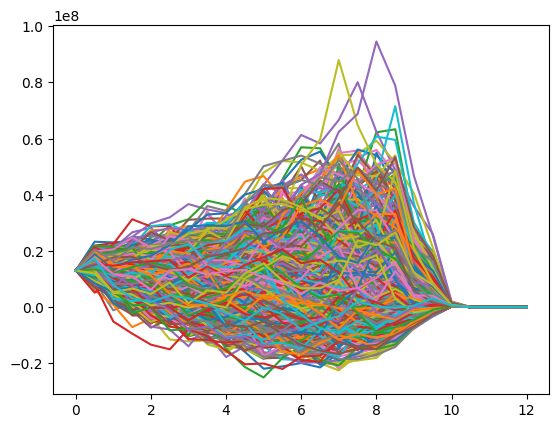

In [ ]:
i = 25
path = 1000
plt.plot(date_grid.times[:i], exposure[:i,:1000]);

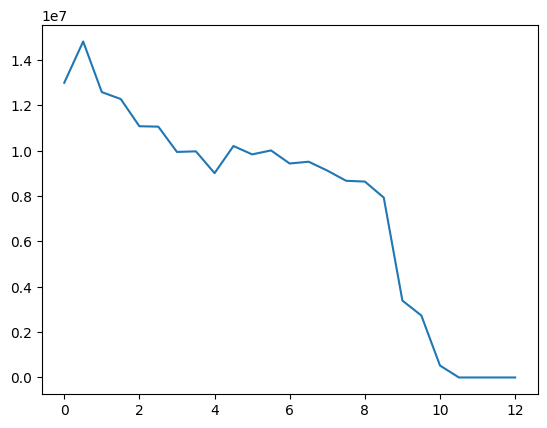

In [ ]:
ee = tf.reduce_mean(exposure, axis=1)
plt.plot(date_grid.times[:i], ee[:i])